In [1]:
# Import package
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# our data frame
df = pd.read_csv(r"C:\Masterpiece By Nickopusan\Document\Video Game\Video game.csv")
df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [3]:
print(f"This data have {df.shape[0]} rows, {df.shape[1]} columns, {df.duplicated().sum()} duplicate, and null : \n{df.isnull().sum()}")

This data have 64016 rows, 14 columns, 0 duplicate, and null : 
img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64


In [4]:
# Delete null in developer
df.dropna(subset='developer', inplace=True)

In [5]:
# Fill null value in last_update same as release_date
df['last_update'] = df['last_update'].fillna(df['release_date'])

In [6]:
# See null in percentage
df.isnull().mean() * 100

img              0.000000
title            0.000000
console          0.000000
genre            0.000000
publisher        0.000000
developer        0.000000
critic_score    89.565462
total_sales     70.440163
na_sales        80.257504
jp_sales        89.490461
pal_sales       79.966874
other_sales     76.366818
release_date    11.007984
last_update      2.728168
dtype: float64

In [7]:
# Make new column "release_year"
df['release_year'] = df['release_date'].apply(lambda x: pd.to_datetime(x).year if pd.notnull(x) else np.nan)

In [8]:
# Predict Critic Score
encode_genre = LabelEncoder()
encode_console = LabelEncoder()

df['genre_encoded'] = encode_genre.fit_transform(df['genre'])
df['console_encoded'] = encode_console.fit_transform(df['console'])

train_df = df.dropna(subset='critic_score')
x = train_df[['genre_encoded', 'console_encoded', 'release_year']]
y = train_df['critic_score']

model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(x, y)

missing_critic = df[df['critic_score'].isnull()]
x_missing = missing_critic[['genre_encoded', 'console_encoded', 'release_year']]
df.loc[df['critic_score'].isnull(), 'critic_score'] = model.predict(x_missing)

df['critic_score'] = df['critic_score'].round(1)

In [9]:
# Predict total sales
train_df = df.dropna(subset='total_sales')
x = train_df[['critic_score', 'genre_encoded', 'console_encoded', 'release_year']]
y = train_df['total_sales']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x, y)
missing_total_sales = df[df['total_sales'].isnull()]
x_missing_total_sales = missing_total_sales[['critic_score', 'genre_encoded', 'console_encoded', 'release_year']]
df.loc[df['total_sales'].isnull(), 'total_sales'] = model.predict(x_missing_total_sales)
df['total_sales'] = df['total_sales'].round(2)

In [10]:
# Predict region sales
region_sales = ['na_sales', 'jp_sales', 'pal_sales', 'other_sales']
for region in region_sales:
    train_df = df.dropna(subset=[region])
    x = train_df[['total_sales', 'critic_score', 'genre_encoded', 'console_encoded', 'release_year']]
    y = train_df[region]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(x, y)
    missing_region_sales = df[df[region].isnull()]
    x_missing_region_sales = missing_region_sales[['total_sales', 'critic_score', 'genre_encoded', 'console_encoded', 'release_year']]
    df.loc[df[region].isnull(), region] = model.predict(x_missing_region_sales)

In [11]:
# Make the decimal only 2 number
df[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']] = df[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].round(2)

In [12]:
# Auto fill release year and release date
df['release_year'] = df.groupby(['genre_encoded', 'console_encoded'])['release_year'].transform(lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else np.nan))
df['release_year'] = df['release_year'].fillna(0)  # Fill NaN values with 0
df['release_date'] = df['release_date'].fillna(df['release_year'].astype(int).astype(str) + '-01-01')

In [13]:
# Make it to null values
df['release_year'] = df['release_year'].replace(0, np.nan)
df['release_date'] = df['release_date'].replace('0-01-01', np.nan)

In [14]:
# Fill release year, date, and last update
df['release_year'].fillna(method='ffill', inplace=True)
df['release_date'] = df['release_date'].fillna(df['release_year'].astype(int).astype(str) + '-01-01')
df['last_update'] = df['last_update'].fillna(df['release_date'])

In [15]:
# See is everything okay
df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update,release_year,genre_encoded,console_encoded
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,2013-09-17,2013.0,0,54
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03,2014.0,0,55
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,2002-10-28,2002.0,0,53
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,8.0,15.86,9.06,0.06,5.33,1.42,2013-09-17,2013-09-17,2013.0,0,73
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14,2015.0,15,55


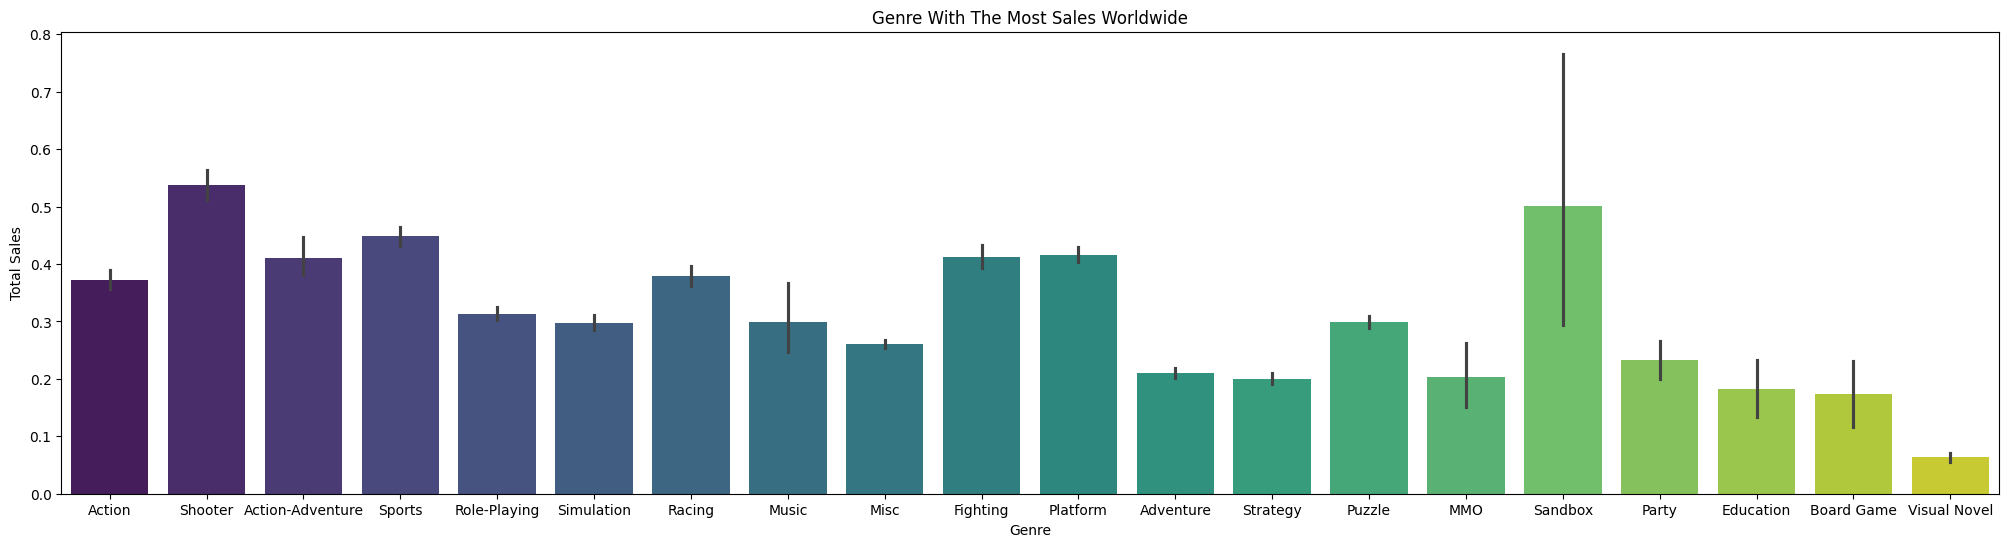

In [16]:
# Genre with the most sales worldwide
plt.figure(figsize=(25, 6))
sns.barplot(x='genre', y='total_sales', data=df, color='red', fill=True, palette='viridis')
plt.title("Genre With The Most Sales Worldwide")
plt.ylabel("Total Sales")
plt.xlabel("Genre")
plt.show()


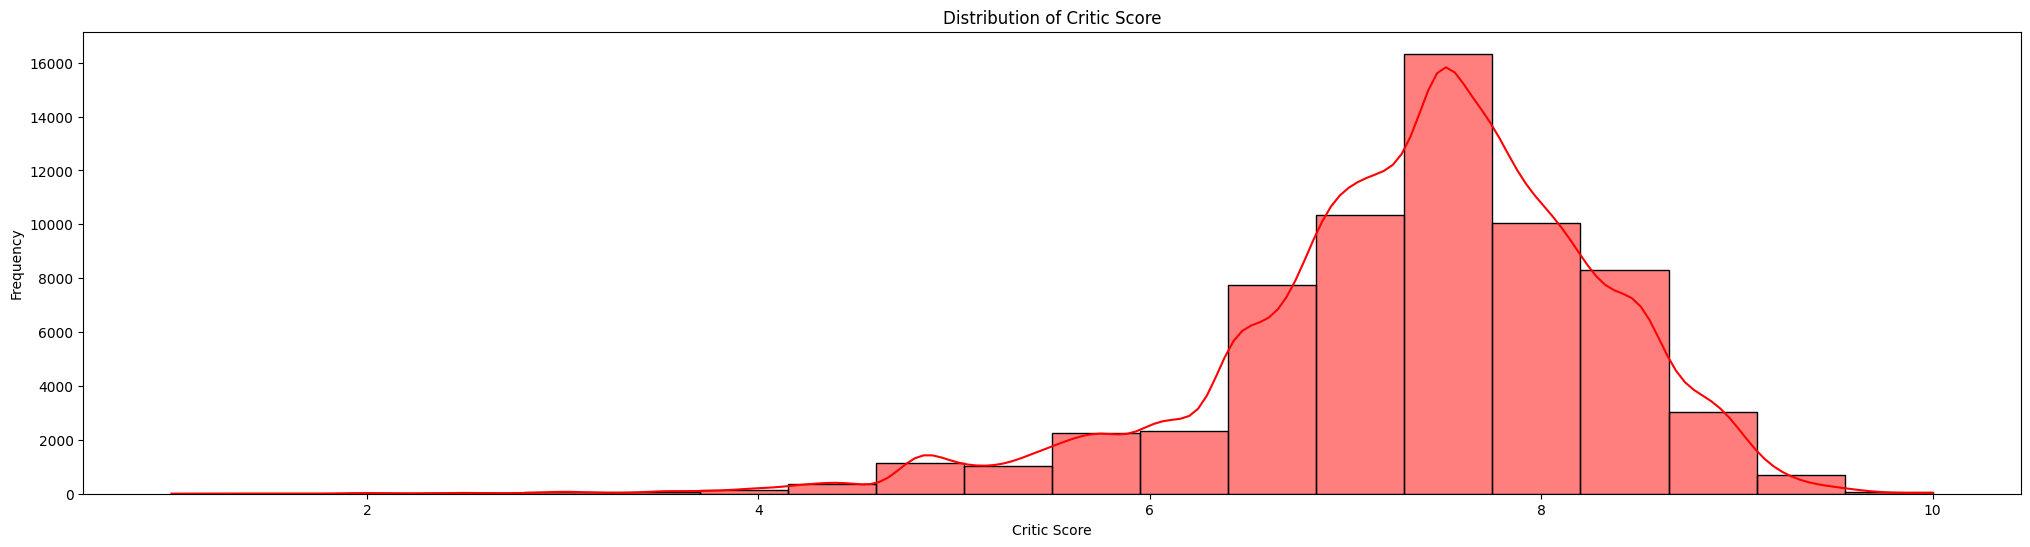

In [17]:
# Distribution of Critic Score
plt.figure(figsize=(25,6))
sns.histplot(df['critic_score'], bins=20, kde=True, color='red')
plt.title("Distribution of Critic Score")
plt.ylabel("Frequency")
plt.xlabel("Critic Score")
plt.show()

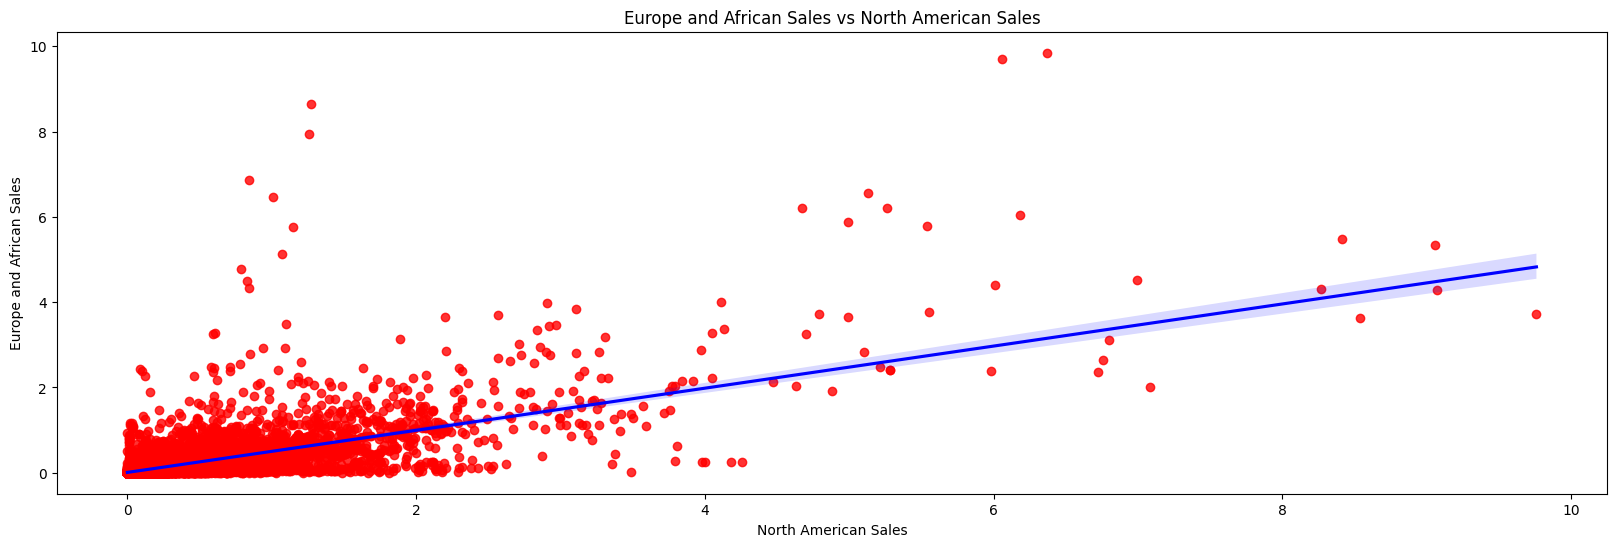

In [18]:
# Europe and African Sales vs North American Sales
plt.figure(figsize=(20,6))
sns.regplot(data=df, x='na_sales', y='pal_sales', scatter_kws={'color':'red'}, line_kws={'color':'blue'})
plt.title("Europe and African Sales vs North American Sales")
plt.ylabel('Europe and African Sales')
plt.xlabel('North American Sales')
plt.show()

In [19]:
print(df[['na_sales', 'pal_sales']].corr(method='pearson'))  # Linear correlation
print(df[['na_sales', 'pal_sales']].corr(method='spearman'))  # Rank-based correlation

           na_sales  pal_sales
na_sales   1.000000   0.702802
pal_sales  0.702802   1.000000
           na_sales  pal_sales
na_sales   1.000000   0.732618
pal_sales  0.732618   1.000000


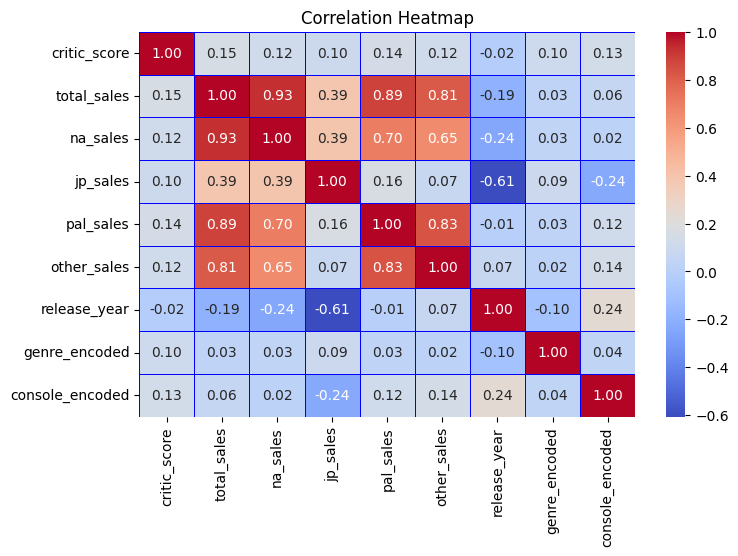

In [20]:
# Correlation Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5, linecolor='blue', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [21]:
# Drop columns
df.drop(columns=['genre_encoded', 'console_encoded'], inplace=True)

In [22]:
# Save to csv for visualizating in power BI
# df.to_csv("Video Game Clean.csv", index=False)